# 5.2 Learning is just parameter estimation

In [9]:
import torch
import numpy as np

In [8]:
import matplotlib.pyplot as plt

- Using Mac GPU 

In [5]:
if torch.backends.mps.is_available():
    mps_device = torch.device('mps')
else:
    print("MPS device not found")

### Data

In [2]:
#input
t_c =  [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

#true labels / observe data
t_u =  [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

#convert into tensor
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

- plot data

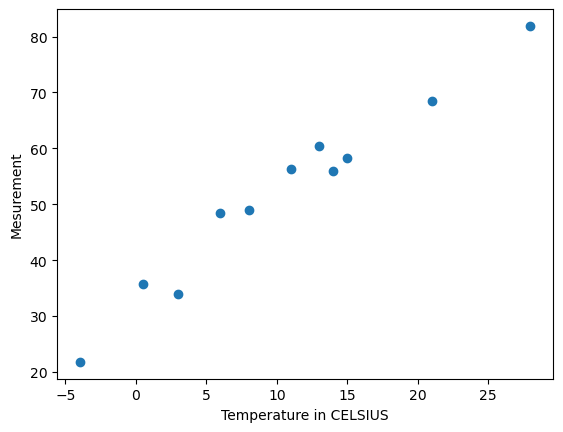

In [17]:
plt.plot(t_c, t_u,'o')
plt.xlabel('Temperature in CELSIUS')
plt.ylabel('Mesurement')
plt.show()

### Linear Model
- Assume the simplest possible model  converting between the two sets of measurement:
    - t_c = w * t_u + b
    - parameters: need to be estimated
        - w :  weight
        - b : bias
    - loss function: objective function : (predictions - targets)**2
        - Square different hellp to penalize large error heavily Ex: 1^2= 1 , 10^2 =100. As exponential curve
- Task:  Minimize the loss
    - estimate weight,bias so that the difference/error between the predictions and the measured values/ground true label/observe data is as low as possible


- Define Model and Loss function

In [98]:
#input data as tensor
# weight,bias : Pytorch scalar - rank-0 tensor
def model(w,b,inputs=t_u):
    out = w * inputs + b
    return out

In [24]:
def loss_fn(preds, targets=t_c):
    ''' return Mean Square Error as MSE
    '''
    squared_diffs = (preds - targets)**2
    mean_sq_diffs = squared_diffs.mean()
    return mean_sq_diffs

- Initialize the parameters

In [74]:
w = torch.ones(())
b = torch.zeros(())

print(w,b)

tensor(1.) tensor(0.)


- Get predictions

In [26]:
preds = model(w,b,t_u)

print(preds)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


In [28]:
# broadcasting
print(w.shape)
print(t_u.shape)

torch.Size([])
torch.Size([11])


In [75]:
w

tensor(1.)

In [77]:
# just create new tensor for w to having rank-1 as array 
t = torch.ones(t_u.shape[0])
t

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [79]:
t * t_u

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

- Calculate loss

In [27]:
loss = loss_fn(preds,t_c)

print(loss)

tensor(1763.8848)


### 5.4.1 Decreasing Loss
- Applying  change to w that is proportional to the  rate of change of the loss is a good idea

- small change in w

In [90]:
delta = 0.1

#Manully estimate rate change of loss function by weight - 
loss_rate_change_w = \
    (loss_fn(model(w + delta ,b,t_u),t_c)) - (loss_fn(model(w - delta, b, t_u),t_c)) / (2.0 * delta)

#scale the rate of change by small factor as Hyper Parameter
learning_rate =1e-2
# adjust weight
w = w - learning_rate * loss_rate_change_w

- small change in b

In [92]:
loss_rate_change_b = \
    (loss_fn(model(w,b + delta,t_u),t_c)) - (loss_fn(model(w, b+delta, t_u),t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_change_b

### 5.4.2 Getting Analytical

- Computing The Derivaties: using chain rule to calculate the derivative of the loss with respect to a parameter:
    - dloss_fn / dw  = (dloss_fn / dpred) * (dpred / dw)
- Derivative will show the direction +/- . To minimize the loss go opposite the directions 

In [93]:
#recall
def loss_fn(preds, targets=t_c):
    ''' return Mean Square Error as MSE
    '''
    squared_diffs = (preds - targets)**2
    mean_sq_diffs = squared_diffs.mean()
    return mean_sq_diffs

In [94]:
#derivative of MSE
def dloss_fn(preds, targets=t_c):
    dsq_diffs = 2 * (preds - targets) / preds.size(0)
    return dsq_diffs

In [96]:
#recall
def model(w,b,inputs=t_u):
    out = w * inputs + b
    return out

In [97]:
#derivative of model respect to w
def dmodel_dw(w,b,inputs=t_u):
    return inputs

In [103]:
#derivative of model respect to b
def dmodel_db(w,b,input_data=t_u):
    return 1.0

- Defining the gradient function

In [99]:
def grad_fn(w,b,preds, inputs=t_u, targets=t_c):
    dloss_dpreds = dloss_fn(preds,targets)
    dloss_dw = dloss_dpreds * dmodel_dw(w,b,inputs)
    dloss_db = dloss_dpreds * dmodel_db(w,b,inputs)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### 5.4.3 Iterating to fit the model

- The Training Loop

In [165]:
def training_loop(n_epochs,learning_rate, params, inputs=t_u, targets=t_c):
    log_file = []
    def get_foat(num):
        if torch.is_tensor(num):
            return float(f"{num.item():.2f}")
    for epoch in range(n_epochs):
        w,b = params
        #forward pass
        preds = model(w,b,inputs)
        #calculate the loss
        loss = loss_fn(preds, targets)

        #calculate gradient
        grad = grad_fn(w,b, preds,inputs,targets)
        #update params
        params = params - learning_rate * grad

        
        #loss log for each 100 epochs
        if epoch % 10 == 0:
            log_obj= {}
            log_obj['epoch'] = epoch
            log_obj['loss'] = float(f"{loss.item():.4f}")
            log_obj['params'] = (float(f"{w.item():.4f}") , float(f"{b.item():.4f}"))
            log_file.append(log_obj)
            
        #log
        if epoch in {1,2,3,10,11,99,100,4000, 5000}:
            print(' Epoch %d, loss %f' % (epoch, float(loss)) )
            print(f'   weight: {w}, bias: {b}')
            print(f'   Grad: {grad}')
        if epoch in {4,12,101}:
            print('.......')
        #explode , vanish gradient - inf  
        if not torch.isfinite(loss).all():
            break
    return  params,log_file

In [166]:
#paramers are too big -> explose gradient
_, log_file = training_loop(100,learning_rate=1e-2,
                            params = torch.tensor([1.0,0.0]),
                            inputs=t_u,targets=t_c)

 Epoch 1, loss 5802484.500000
   weight: -44.1729621887207, bias: -0.8259999752044678
   Grad: tensor([-261257.4062,   -4598.9702])
 Epoch 2, loss 19408029696.000000
   weight: 2568.401123046875, bias: 45.163700103759766
   Grad: tensor([15109614.0000,   266155.6875])
 Epoch 3, loss 64915905708032.000000
   weight: -148527.734375, bias: -2616.39306640625
   Grad: tensor([-8.7385e+08, -1.5393e+07])
.......
 Epoch 10, loss inf
   weight: 3.214415715452846e+17, bias: 5662125716406272.0
   Grad: tensor([1.8912e+21, 3.3313e+19])


In [167]:
#params is too small -> loss decrease slowly
_, log_file = training_loop(100,learning_rate=1e-4,
                            params = torch.tensor([1.0,0.0]),
                            inputs=t_u,targets=t_c)

 Epoch 1, loss 323.090515
   weight: 0.5482703447341919, bias: -0.008259999565780163
   Grad: tensor([1859.5493,   35.7843])
 Epoch 2, loss 78.929634
   weight: 0.36231541633605957, bias: -0.011838428676128387
   Grad: tensor([765.4666,  16.5122])
 Epoch 3, loss 37.552845
   weight: 0.2857687473297119, bias: -0.013489648699760437
   Grad: tensor([315.0790,   8.5787])
.......
 Epoch 10, loss 29.104168
   weight: 0.23235063254833221, bias: -0.016550514847040176
   Grad: tensor([0.5781, 3.0384])
 Epoch 11, loss 29.103222
   weight: 0.23229283094406128, bias: -0.016854356974363327
   Grad: tensor([0.2066, 3.0318])
.......
 Epoch 99, loss 29.022667
   weight: 0.23271755874156952, bias: -0.04347465932369232
   Grad: tensor([-0.0532,  3.0226])


### 5.5.4 Normalizing Inputs
- first training : Gradient for weights is 50 times larger than gradient for bias . Scale Space for weights are different from one for bias

- Resacle inputs

In [168]:
t_u #before

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [169]:
t_un = t_u * 0.1
t_un #after

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])

In [170]:
_,log_file = training_loop(
    n_epochs=100,
    learning_rate=1e-2,
    params = torch.tensor([1.0,0.0]),
    inputs = t_un,
    targets= t_c
)

 Epoch 1, loss 37.574913
   weight: 1.7761404514312744, bias: 0.10639999061822891
   Grad: tensor([-30.8623,  -2.3864])
 Epoch 2, loss 30.871077
   weight: 2.084763288497925, bias: 0.13026383519172668
   Grad: tensor([-12.4631,   0.8587])
 Epoch 3, loss 29.756193
   weight: 2.2093942165374756, bias: 0.12167706340551376
   Grad: tensor([-5.2218,  2.1327])
.......
 Epoch 10, loss 28.941877
   weight: 2.3232028484344482, bias: -0.07098992168903351
   Grad: tensor([-0.5240,  2.9264])
 Epoch 11, loss 28.853565
   weight: 2.3284430503845215, bias: -0.10025395452976227
   Grad: tensor([-0.5190,  2.9222])
.......
 Epoch 99, loss 22.148710
   weight: 2.7508292198181152, bias: -2.4910454750061035
   Grad: tensor([-0.4446,  2.5165])


- n_epochs = 5000

In [199]:
params ,log_file = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params = torch.tensor([1.0,0.0]),
    inputs = t_un,
    targets= t_c
)

 Epoch 1, loss 37.574913
   weight: 1.7761404514312744, bias: 0.10639999061822891
   Grad: tensor([-30.8623,  -2.3864])
 Epoch 2, loss 30.871077
   weight: 2.084763288497925, bias: 0.13026383519172668
   Grad: tensor([-12.4631,   0.8587])
 Epoch 3, loss 29.756193
   weight: 2.2093942165374756, bias: 0.12167706340551376
   Grad: tensor([-5.2218,  2.1327])
.......
 Epoch 10, loss 28.941877
   weight: 2.3232028484344482, bias: -0.07098992168903351
   Grad: tensor([-0.5240,  2.9264])
 Epoch 11, loss 28.853565
   weight: 2.3284430503845215, bias: -0.10025395452976227
   Grad: tensor([-0.5190,  2.9222])
.......
 Epoch 99, loss 22.148710
   weight: 2.7508292198181152, bias: -2.4910454750061035
   Grad: tensor([-0.4446,  2.5165])
 Epoch 100, loss 22.083464
   weight: 2.755274772644043, bias: -2.5162105560302734
   Grad: tensor([-0.4438,  2.5122])
.......
 Epoch 4000, loss 2.927680
   weight: 5.364270210266113, bias: -17.285263061523438
   Grad: tensor([-0.0006,  0.0033])


#### Analyse the model

In [197]:
def show_loss(log_file,is_showLoss=True):
    epochs  = [ lf['epoch']for lf in log_file]
    losses =    [ lf['loss'] for lf in log_file]
    params = [ lf['params'] for lf in log_file ]
    weights ,bias = zip(*params)
    if is_showLoss:
        plt.plot(epochs,losses)
        plt.xlabel('epochs')
        plt.ylabel('losses')
        plt.show()

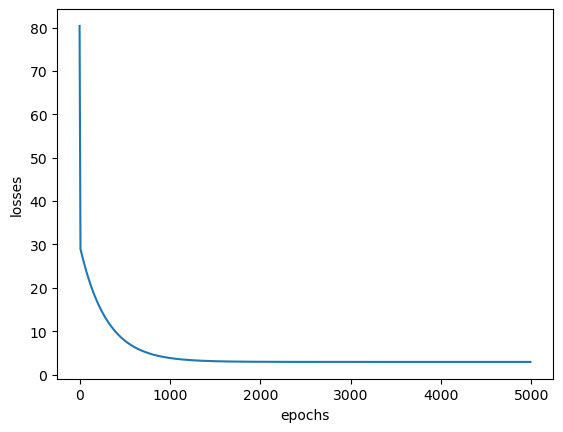

In [198]:
show_loss(log_file)

## 5.4.5 Visualize 
- plot the params

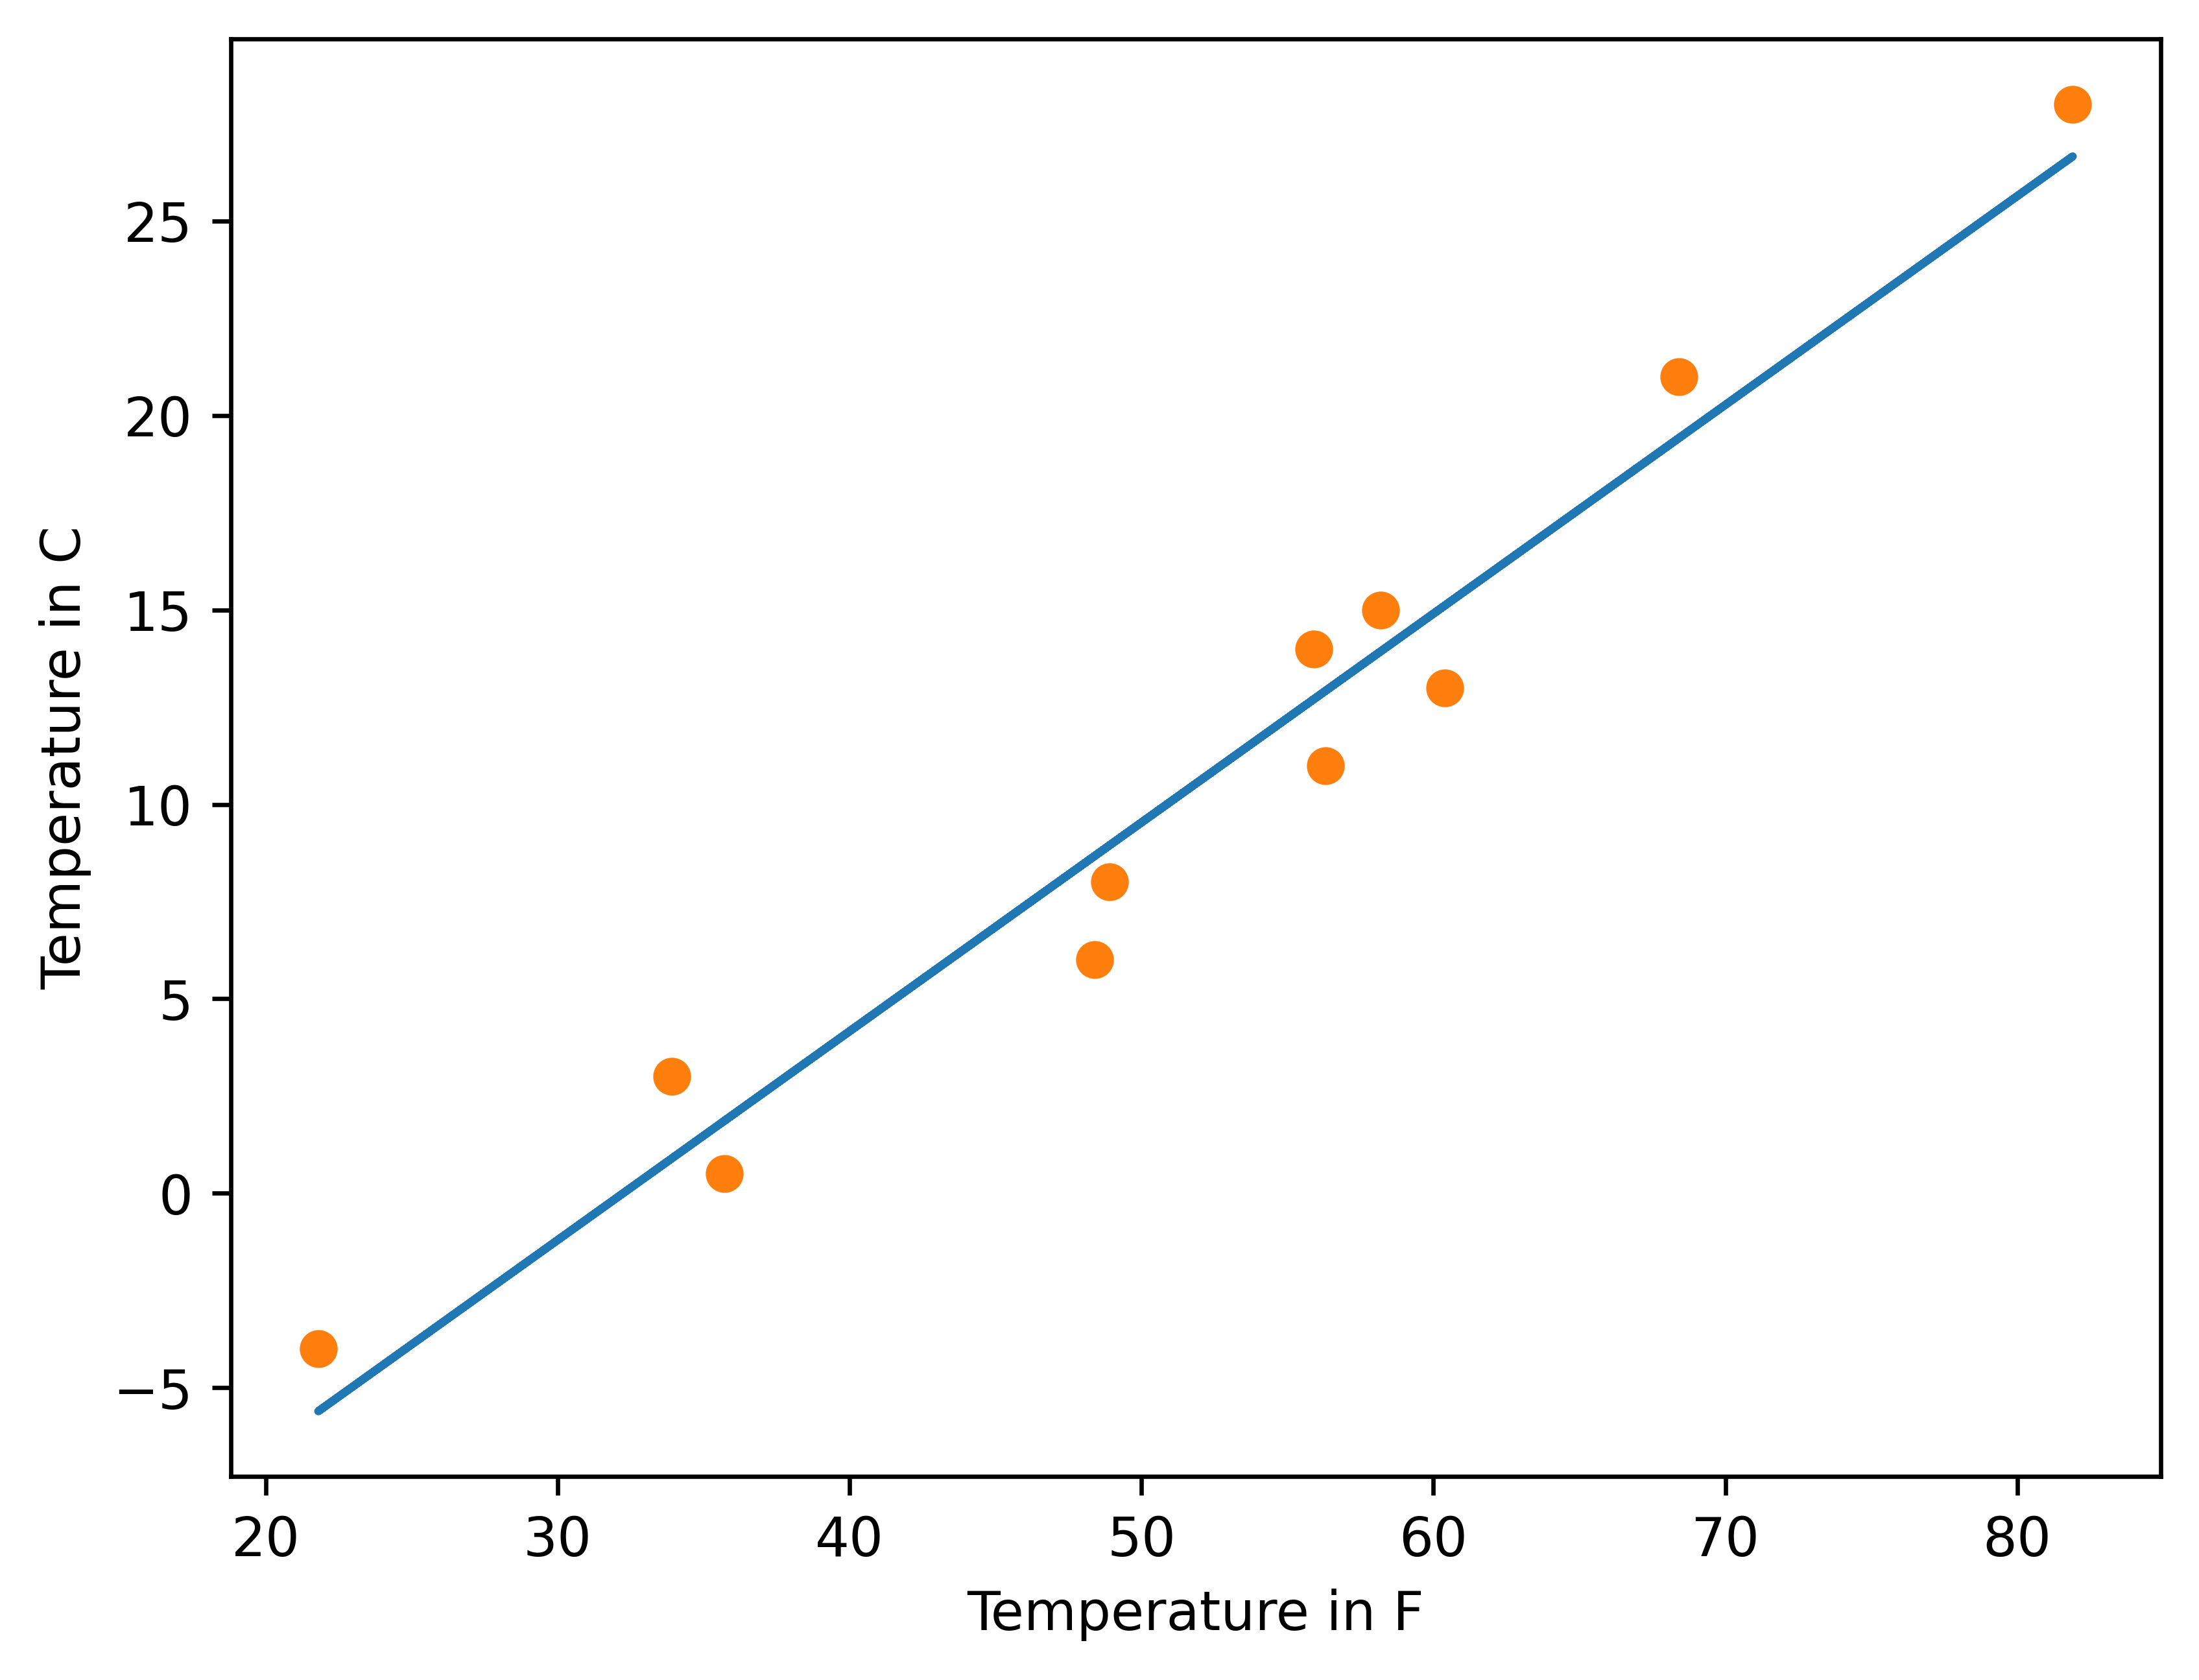

In [201]:
preds = model(*params,inputs=t_un)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature in F")
plt.ylabel("Temperature in C")
plt.plot(t_u.numpy(), preds.detach().numpy()) # predictions
plt.plot(t_u.numpy(), t_c.numpy(), 'o') #targets point

### 5.5.1 Computing the gradient automatically

In [ ]:
#model
def model(w,b,inputs=t_u):
    out = w * inputs + b
    return out

In [202]:
#loss function
def loss_fn(preds, targets=t_c):
    ''' return Mean Square Error as MSE
    '''
    squared_diffs = (preds - targets)**2
    mean_sq_diffs = squared_diffs.mean()
    return mean_sq_diffs

In [206]:
#initialize params with grad tracking
params = torch.tensor([1.0,0.0],requires_grad=True)

In [208]:
#
params.grad is None

True

- Use grad attribute

In [209]:
preds = model(*params,t_u)
loss =loss_fn(preds,t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

- Accumulating grad functions:
    - need to set grad=0 at each iteraton explicitly

In [210]:
if params.grad is not None:
    params.grad.zero_()

In [211]:
params.grad

tensor([0., 0.])

- Training with auto backprop

In [223]:
def train(params,n_epochs=100, learning_rate=1e-3, inputs=t_u, targets=t_c):
    for epoch in range(1, n_epochs+1):
        w,b = params
        #forward pass
        preds = model(w,b,inputs)
        loss = loss_fn(preds,targets)
        #backward pass 
        if params.grad is not None:
            params.grad.zero_() 
        loss.backward()
        #update all params whole network
        with torch.no_grad(): 
            params -= learning_rate * params.grad 
        
        #log
        if epoch % 500 == 0 :
            print(f"Epoch: {epoch} - loss:{loss:.4f}")
    return params

In [228]:
#using scaled inputs -> avoid explore gradients
train(params=torch.tensor([1.0,0.0],requires_grad=True),
      n_epochs= 5000,
      learning_rate=1e-2,
      inputs=t_un,
      targets=t_c)

Epoch: 500 - loss:7.8601
Epoch: 1000 - loss:3.8285
Epoch: 1500 - loss:3.0922
Epoch: 2000 - loss:2.9577
Epoch: 2500 - loss:2.9331
Epoch: 3000 - loss:2.9286
Epoch: 3500 - loss:2.9278
Epoch: 4000 - loss:2.9277
Epoch: 4500 - loss:2.9277
Epoch: 5000 - loss:2.9276


tensor([  5.3671, -17.3012], requires_grad=True)

## Side Play


In [85]:
# Zero rank - 0 dimension - Pytorch scalar

t_sc = torch.tensor(3)
t_sc

tensor(3)

In [86]:
# tensor rank-1
t_1 = torch.tensor([2,3,4])

In [87]:
#broadcasting 
t_sc * t_1

tensor([ 6,  9, 12])

In [89]:
# how to broadcasting scalar
t = torch.ones(3) # create rank-1 tensor
t[:] = t_sc # fill with scalar
print(t)

tensor([3., 3., 3.])
